# Positional embedding for Image Classification

---

## Motivation
We discussed in class the inductive biases of different architectures:
1) **CNNs** exploit **locality** and **stationarity**. They work well on images because neighboring pixels are highly correlated. If the image's structure is disrupted, it should fail.

2) **Attention mechanisms** are naturally **permutation invariant**—they treat the input as a set of tokens without inherent order (like a "bag of words").

3) To handle sequences where order matters (like text: "Horse eat apple" vs "apple eat Horse"), Attention mechanisms use **positional embeddings** to distinguish the order of tokens.

This project investigates how neccessary it is to use positional embedding in an attention mechanism when the input is an image.

---

## Core Question
If we convert an image into patches and treat them as tokens, how can we classify images with similar sets of patches?

---

## Hypothesis
My hypothesis is that **images sharing similar sets of patches require positional embeddings for the model to perform well**.
While a simple "bag of patches" might suffice for distinct images (e.g., a "1" vs an "8"), it should fail when the patches are similar but the geometry defines the class (e.g., a "6" vs a "9").

---

## The plan
1) **Hypothesis**: Images sharing similar sets of patches require positional embeddings to be classified correctly.
2) **Experiment**:
    - Create a **Jigsaw MNIST** dataset where image patches are shuffled.
    - Train a **CNN** (baseline) to show it fails without locality.
    - Train an **Attention Model (No Position)** to see if patch content alone is enough.
    - Train an **Attention Model (With Position)** to see if learning "where" each patch goes solves the problem.
3) **Measurement**: Test Accuracy on Normal vs. Jigsaw images
4) **Analysis**: Compare the effect of positional embedding on the model's performance.
5) **Conclusion**: Demonstrate that while patch content carries much needed information, positional embedding is critical for geometric understanding.

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def set_seed(seed = 31):
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
set_seed(31)

cuda


## Task definition: Jigsaw
We interpret an image as a grid of $4 \times 4$ patches.
- **Normal**: Patches are in their original order.
- **Jigsaw**: The $7 \times 7 = 49$ patches are randomly permuted.

This destroys the local neighborhood structure that CNNs rely on.

In [2]:
def image_to_patches(img):
    patches = []
    pos = []
    idx = 0
    for i in range(7):
        for j in range(7):
            patch = img[:, i*4:(i+1)*4, j*4:(j+1)*4]
            patches.append(patch.reshape(-1))
            pos.append(idx)
            idx += 1
    return torch.stack(patches), torch.tensor(pos)

def patches_to_image(patches):
    img = torch.zeros(1, 28, 28)
    idx = 0
    for i in range(7):
        for j in range(7):
            img[:, i*4:(i+1)*4, j*4:(j+1)*4] = patches[idx].reshape(1,4,4)
            idx += 1
    return img

def make_jigsaw(img):
    patches, pos = image_to_patches(img)
    perm = torch.randperm(len(patches))
    patches = patches[perm]
    pos = pos[perm]
    jigsaw_img = patches_to_image(patches)
    return jigsaw_img, patches, pos

In [3]:
def filter_mnist_balanced(dataset, allowed_digits, max_samples_per_digit):

    final_indices = []

    for digit in allowed_digits:

        digit_indices = [i for i, (_, y) in enumerate(dataset) if y == digit]

        if len(digit_indices) < max_samples_per_digit:
            print(f"Digit {digit} only has {len(digit_indices)} samples.")
            final_indices.extend(digit_indices)
        else:
            final_indices.extend(digit_indices[:max_samples_per_digit])
            print(f"Using {max_samples_per_digit} samples for digit {digit}.")
    return Subset(dataset, final_indices)

def make_subset_loaders(allowed_digits, train_samples_per_digit=5000, test_samples_per_digit=800):

    train_batch = 128
    test_batch = 128

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_raw = datasets.MNIST(root='.', train=True, download=True, transform=transform)
    test_raw = datasets.MNIST(root='.', train=False, download=True, transform=transform)

    print("Trainset")
    trainset_sub = filter_mnist_balanced(train_raw, allowed_digits, train_samples_per_digit)
    print("-"*50)
    print("Testset")
    testset_sub  = filter_mnist_balanced(test_raw, allowed_digits, test_samples_per_digit)
    print("-"*50)

    train_loader = DataLoader(trainset_sub, batch_size=train_batch, shuffle=True)
    test_loader = DataLoader(testset_sub, batch_size=test_batch, shuffle=False)

    return train_loader, test_loader

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.00MB/s]


Trainset
Using 5400 samples for digit 0.
Using 5400 samples for digit 1.
Using 5400 samples for digit 2.
Using 5400 samples for digit 3.
Using 5400 samples for digit 4.
Using 5400 samples for digit 5.
Using 5400 samples for digit 6.
Using 5400 samples for digit 7.
Using 5400 samples for digit 8.
Using 5400 samples for digit 9.
--------------------------------------------------
Testset
Using 890 samples for digit 0.
Using 890 samples for digit 1.
Using 890 samples for digit 2.
Using 890 samples for digit 3.
Using 890 samples for digit 4.
Using 890 samples for digit 5.
Using 890 samples for digit 6.
Using 890 samples for digit 7.
Using 890 samples for digit 8.
Using 890 samples for digit 9.
--------------------------------------------------
Trainset
Using 5800 samples for digit 1.
Using 5800 samples for digit 8.
--------------------------------------------------
Testset
Using 950 samples for digit 1.
Using 950 samples for digit 8.
--------------------------------------------------
Trains

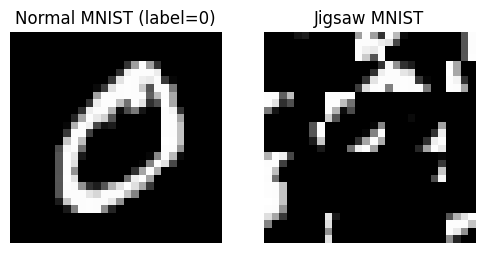

In [4]:
train_loader_0_9, test_loader_0_9 = make_subset_loaders([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 5400, 890)
train_loader_18, test_loader_18 = make_subset_loaders([1, 8], 5800, 950)
train_loader_69, test_loader_69 = make_subset_loaders([6, 9], 5800, 950)

img, label = train_loader_0_9.dataset[0]
jigsaw_img, _, _ = make_jigsaw(img)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Normal MNIST (label={label})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(jigsaw_img.squeeze(), cmap="gray")
plt.title("Jigsaw MNIST")
plt.axis("off")

plt.show()


## Convolutional Neural Network

CNNs have a strong inductive bias for **locality**.
- **Prediction**: This model should perform well on normal images but fail on Jigsaw images because the local features (edges across patch boundaries) are broken.

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(6, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 120, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(120 * 3 * 3, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x


In [6]:
loss_fn = nn.CrossEntropyLoss()

def train_cnn(model, opt, train_loader, epochs=5):

    set_seed(31)

    model.train()

    losses = []
    steps = []
    step_count = 0

    for epoch in range(epochs):
        for i, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            preds = model(imgs)
            loss = loss_fn(preds, labels)
            opt.zero_grad()
            loss.backward()
            opt.step()

            step_count += 1

            if step_count % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], "f"Step [{i+1}/{len(train_loader)}], "f"Loss: {loss.item():.4f}")
            if step_count % 50 == 0:
              losses.append(loss.item())
              steps.append(step_count)


    return steps, losses

In [7]:
def eval_cnn(model, test_loader, jigsaw=False):
    model.eval()
    correct, total = 0, 0
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        if jigsaw:
            imgs = torch.stack([make_jigsaw(img)[0] for img in imgs]).to(device)
        preds = model(imgs).argmax(-1)
        correct += (preds == labels).sum().item()
        total += labels.shape[0]
    return correct / total

In [8]:
set_seed(31)

cnn = CNN().to(device)
cnn_opt = torch.optim.SGD(cnn.parameters(), lr=0.01)
steps, losses = train_cnn(cnn, cnn_opt, train_loader_0_9, epochs=10)


Epoch [1/10], Step [100/422], Loss: 2.2588
Epoch [1/10], Step [200/422], Loss: 2.0892
Epoch [1/10], Step [300/422], Loss: 1.0018
Epoch [1/10], Step [400/422], Loss: 0.5524
Epoch [2/10], Step [78/422], Loss: 0.5287
Epoch [2/10], Step [178/422], Loss: 0.5000
Epoch [2/10], Step [278/422], Loss: 0.3728
Epoch [2/10], Step [378/422], Loss: 0.2062
Epoch [3/10], Step [56/422], Loss: 0.2921
Epoch [3/10], Step [156/422], Loss: 0.2588
Epoch [3/10], Step [256/422], Loss: 0.2223
Epoch [3/10], Step [356/422], Loss: 0.2349
Epoch [4/10], Step [34/422], Loss: 0.1495
Epoch [4/10], Step [134/422], Loss: 0.2636
Epoch [4/10], Step [234/422], Loss: 0.3252
Epoch [4/10], Step [334/422], Loss: 0.1671
Epoch [5/10], Step [12/422], Loss: 0.1226
Epoch [5/10], Step [112/422], Loss: 0.1327
Epoch [5/10], Step [212/422], Loss: 0.1443
Epoch [5/10], Step [312/422], Loss: 0.0996
Epoch [5/10], Step [412/422], Loss: 0.1652
Epoch [6/10], Step [90/422], Loss: 0.1688
Epoch [6/10], Step [190/422], Loss: 0.0632
Epoch [6/10], St

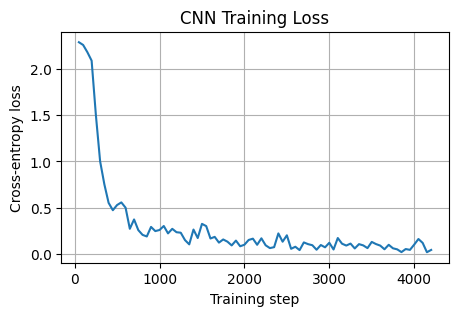

In [9]:
plt.figure(figsize=(5,3))
plt.plot(steps, losses)
plt.xlabel("Training step")
plt.ylabel("Cross-entropy loss")
plt.title("CNN Training Loss")
plt.grid(True)
plt.show()

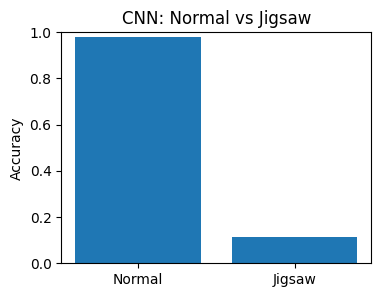


 Accuracy for Normal Image: 0.9789887640449438 
 Accuracy for Jigsaw Image: 0.11179775280898877


In [10]:
cnn_normal = eval_cnn(cnn, test_loader_0_9, jigsaw=False)
cnn_jigsaw = eval_cnn(cnn, test_loader_0_9, jigsaw=True)

plt.figure(figsize=(4,3))
plt.bar(["Normal", "Jigsaw"], [cnn_normal, cnn_jigsaw])
plt.ylabel("Accuracy")
plt.title("CNN: Normal vs Jigsaw")
plt.ylim(0,1)
plt.show()

print(f"\n Accuracy for Normal Image: {cnn_normal}", f"\n Accuracy for Jigsaw Image: {cnn_jigsaw}")

## Method 2: Attention without Positional embedding

Here we treat the image strictly as a **set of patches**. The model sees the patches but has no idea *where* they are in the image.

- **Prediction**: This model is **permutation invariant**. It should give the exact same accuracy on Normal and Jigsaw images. However, it may struggle with digits that require geometry (like 6 vs 9).

In [11]:
class AttnNoPos(nn.Module):
    def __init__(self, d=64):
        super().__init__()
        self.d = d
        self.patch = nn.Linear(16,d)
        self.query = nn.Parameter(torch.randn(d))
        self.cls = nn.Sequential(nn.Linear(d, 128),nn.ReLU(),nn.Linear(128, 10))

    def forward(self, patches):
        tokens = self.patch(patches)
        q = self.query / math.sqrt(self.d)
        scores = (tokens * q).sum(dim=-1)
        a = F.softmax(scores, dim=1)
        pooled = (tokens * a.unsqueeze(-1)).sum(dim=1)
        return self.cls(pooled)

In [12]:
loss_fn = nn.CrossEntropyLoss()

def train_attn_nopos(model, opt, train_loader, epochs=5):
    set_seed(31)

    model.train()

    losses = []
    steps = []
    step_count = 0

    for epoch in range(epochs):
        for i, (imgs, labels) in enumerate(train_loader):

            labels = labels.to(device)
            patches = torch.stack([image_to_patches(img)[0] for img in imgs]).to(device)

            preds = model(patches)
            loss = loss_fn(preds, labels)
            opt.zero_grad()
            loss.backward()
            opt.step()

            step_count += 1
            if step_count % 200 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], " f"Step [{i+1}/{len(train_loader)}], "f"Loss: {loss.item():.4f}")
            if step_count % 50 == 0:
              losses.append(loss.item())
              steps.append(step_count)

    return steps, losses

In [13]:
def eval_attn_nopos(model, test_loader, jigsaw=False):
    model.eval()
    correct, total = 0, 0

    for imgs, labels in test_loader:
        labels = labels.to(device)

        if jigsaw:
            patches, _ = zip(*[make_jigsaw(img)[1:] for img in imgs])
        else:
            patches, _ = zip(*[image_to_patches(img) for img in imgs])

        patches = torch.stack(patches).to(device)

        preds = model(patches).argmax(-1)

        correct += (preds == labels).sum().item()
        total += labels.shape[0]

    return correct / total

In [14]:
set_seed(31)

attn_nopos = AttnNoPos().to(device)
attn_nopos_opt = torch.optim.SGD(attn_nopos.parameters(), lr=0.01)
steps_nopos, losses_nopos = train_attn_nopos(attn_nopos, attn_nopos_opt, train_loader_0_9, epochs=10)


Epoch [1/10], Step [200/422], Loss: 2.2781
Epoch [1/10], Step [400/422], Loss: 2.2582
Epoch [2/10], Step [178/422], Loss: 2.2384
Epoch [2/10], Step [378/422], Loss: 2.1530
Epoch [3/10], Step [156/422], Loss: 2.1224
Epoch [3/10], Step [356/422], Loss: 2.0098
Epoch [4/10], Step [134/422], Loss: 2.0050
Epoch [4/10], Step [334/422], Loss: 1.9131
Epoch [5/10], Step [112/422], Loss: 1.8922
Epoch [5/10], Step [312/422], Loss: 1.9904
Epoch [6/10], Step [90/422], Loss: 2.0151
Epoch [6/10], Step [290/422], Loss: 1.9726
Epoch [7/10], Step [68/422], Loss: 1.8896
Epoch [7/10], Step [268/422], Loss: 1.9674
Epoch [8/10], Step [46/422], Loss: 1.8863
Epoch [8/10], Step [246/422], Loss: 1.8697
Epoch [9/10], Step [24/422], Loss: 1.7590
Epoch [9/10], Step [224/422], Loss: 1.9122
Epoch [10/10], Step [2/422], Loss: 1.8571
Epoch [10/10], Step [202/422], Loss: 1.8775
Epoch [10/10], Step [402/422], Loss: 1.8661


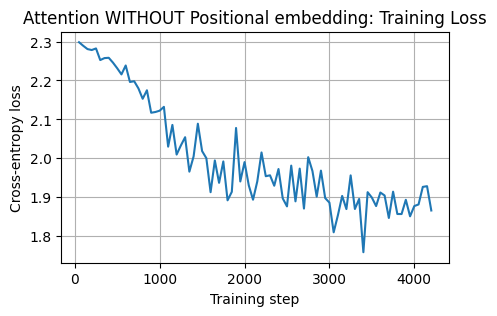

In [15]:
plt.figure(figsize=(5,3))
plt.plot(steps_nopos, losses_nopos)
plt.xlabel("Training step")
plt.ylabel("Cross-entropy loss")
plt.title("Attention WITHOUT Positional embedding: Training Loss")
plt.grid(True)
plt.show()

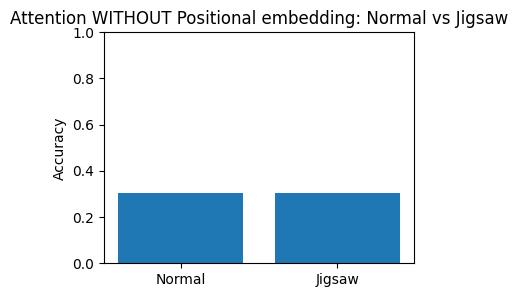


 Accuracy for Normal Image: 0.30314606741573036 
 Accuracy for Jigsaw Image: 0.30314606741573036


In [16]:
attn_nopos_normal = eval_attn_nopos(attn_nopos, test_loader_0_9, jigsaw=False)
attn_nopos_jigsaw = eval_attn_nopos(attn_nopos, test_loader_0_9, jigsaw=True)

plt.figure(figsize=(4,3))
plt.bar(["Normal", "Jigsaw"], [attn_nopos_normal, attn_nopos_jigsaw])
plt.ylabel("Accuracy")
plt.title("Attention WITHOUT Positional embedding: Normal vs Jigsaw")
plt.ylim(0,1)
plt.show()


print(f"\n Accuracy for Normal Image: {attn_nopos_normal} " f"\n Accuracy for Jigsaw Image: {attn_nopos_jigsaw}")

In [17]:
set_seed(31)

attn_18 = AttnNoPos().to(device)
attn_18_opt = torch.optim.SGD(attn_18.parameters(), lr=0.01)
steps_nopos, losses_nopos = train_attn_nopos(attn_18, attn_18_opt, train_loader_18, epochs=10)



Epoch [3/10], Step [18/91], Loss: 0.5289
Epoch [5/10], Step [36/91], Loss: 0.2729
Epoch [7/10], Step [54/91], Loss: 0.1610
Epoch [9/10], Step [72/91], Loss: 0.1273


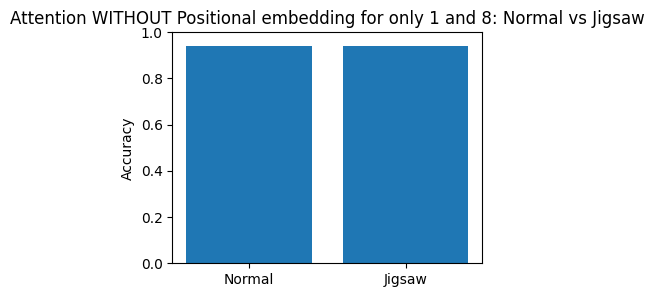


 Accuracy for Normal Image: 0.9426315789473684 
 Accuracy for Jigsaw Image: 0.9426315789473684


In [18]:
attn_18_normal = eval_attn_nopos(attn_18, test_loader_18, jigsaw=False)
attn_18_jigsaw = eval_attn_nopos(attn_18, test_loader_18, jigsaw=True)

plt.figure(figsize=(4,3))
plt.bar(["Normal", "Jigsaw"], [attn_18_normal, attn_18_jigsaw])
plt.ylabel("Accuracy")
plt.title("Attention WITHOUT Positional embedding for only 1 and 8: Normal vs Jigsaw")
plt.ylim(0,1)
plt.show()


print(f"\n Accuracy for Normal Image: {attn_18_normal} " f"\n Accuracy for Jigsaw Image: {attn_18_jigsaw}")

In [19]:
set_seed(31)

attn_69 = AttnNoPos().to(device)
attn_69_opt = torch.optim.SGD(attn_69.parameters(), lr=0.01)
steps_nopos, losses_nopos = train_attn_nopos(attn_69, attn_69_opt, train_loader_69, epochs=10)

Epoch [3/10], Step [18/91], Loss: 0.7058
Epoch [5/10], Step [36/91], Loss: 0.6515
Epoch [7/10], Step [54/91], Loss: 0.6721
Epoch [9/10], Step [72/91], Loss: 0.6456


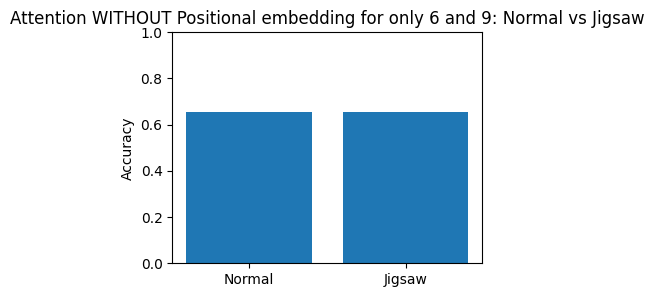


 Accuracy for Normal Image: 0.6536842105263158 
 Accuracy for Jigsaw Image: 0.6536842105263158


In [20]:
attn_69_normal = eval_attn_nopos(attn_69, test_loader_69, jigsaw=False)
attn_69_jigsaw = eval_attn_nopos(attn_69, test_loader_69, jigsaw=True)

plt.figure(figsize=(4,3))
plt.bar(["Normal", "Jigsaw"], [attn_69_normal, attn_69_jigsaw])
plt.ylabel("Accuracy")
plt.title("Attention WITHOUT Positional embedding for only 6 and 9: Normal vs Jigsaw")
plt.ylim(0,1)
plt.show()


print(f"\n Accuracy for Normal Image: {attn_69_normal} " f"\n Accuracy for Jigsaw Image: {attn_69_jigsaw}")

## Method 3: Attention with Positional embedding

We add a learnable vector for each of the 49 positions.

- **Prediction**: The model can now learn to "reassemble" the image mentally. Even if the patches are shuffled in the input (Jigsaw), the positional feature allows it to understand the geometry.

In [21]:
class AttnWithPos(nn.Module):
    def __init__(self, d=64):
        super().__init__()
        self.d = d
        self.patch = nn.Linear(16,d)
        self.pos = nn.Embedding(49,d)
        self.query = nn.Parameter(torch.randn(d))
        self.cls = nn.Sequential(nn.Linear(d, 128),nn.ReLU(),nn.Linear(128, 10))

    def forward(self, patches, pos):
        tokens = self.patch(patches) + self.pos(pos)
        q = self.query / math.sqrt(self.d)
        scores = (tokens * q).sum(dim=-1)
        w = F.softmax(scores, dim=1)
        pooled = (tokens * w.unsqueeze(-1)).sum(dim=1)
        return self.cls(pooled)

In [22]:
loss_fn = nn.CrossEntropyLoss()

def train_attn_pos(model, opt, train_loader, epochs=5):
    set_seed(31)

    model.train()

    losses = []
    steps = []
    step_count = 0

    for epoch in range(epochs):
        for i, (imgs, labels) in enumerate(train_loader):

            labels = labels.to(device)
            patches, pos = zip(*[image_to_patches(img) for img in imgs])
            patches = torch.stack(patches).to(device)
            pos = torch.stack(pos).to(device)

            preds = model(patches, pos)
            loss = loss_fn(preds, labels)
            opt.zero_grad()
            loss.backward()
            opt.step()

            step_count += 1

            if step_count % 200 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], " f"Step [{i+1}/{len(train_loader)}], " f"Loss: {loss.item():.4f}")
            if step_count % 50 == 0:
              losses.append(loss.item())
              steps.append(step_count)

    return steps, losses

In [23]:
def eval_attn_pos(model, test_loader, jigsaw=False):
    model.eval()
    correct, total = 0, 0

    for imgs, labels in test_loader:
        labels = labels.to(device)

        if jigsaw:
            patches, pos = zip(*[make_jigsaw(img)[1:] for img in imgs])
        else:
            patches, pos = zip(*[image_to_patches(img) for img in imgs])

        patches = torch.stack(patches).to(device)
        pos = torch.stack(pos).to(device)

        preds = model(patches, pos).argmax(-1)
        correct += (preds == labels).sum().item()
        total += labels.shape[0]

    return correct / total


In [24]:
set_seed(31)

attn_18pos = AttnWithPos().to(device)
attn_18pos_opt = torch.optim.SGD(attn_18pos.parameters(), lr=0.01)
steps_pos, losses_pos = train_attn_pos(attn_18pos, attn_18pos_opt, train_loader_18, epochs=10)

Epoch [3/10], Step [18/91], Loss: 0.3676
Epoch [5/10], Step [36/91], Loss: 0.2238
Epoch [7/10], Step [54/91], Loss: 0.1978
Epoch [9/10], Step [72/91], Loss: 0.2191


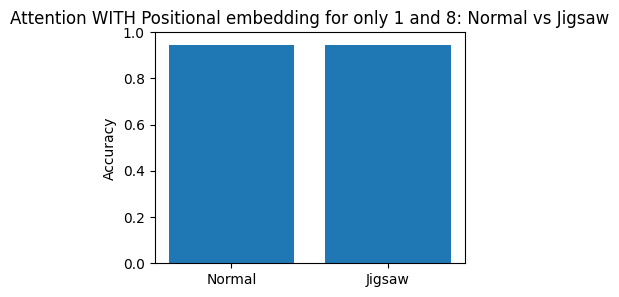


 Accuracy for Normal Image: 0.9442105263157895 
 Accuracy for Jigsaw Image: 0.9442105263157895


In [25]:
attn_18pos_normal = eval_attn_pos(attn_18pos, test_loader_18, jigsaw=False)
attn_18pos_jigsaw = eval_attn_pos(attn_18pos, test_loader_18, jigsaw=True)

plt.figure(figsize=(4,3))
plt.bar(["Normal", "Jigsaw"], [attn_18pos_normal, attn_18pos_jigsaw])
plt.ylabel("Accuracy")
plt.title("Attention WITH Positional embedding for only 1 and 8: Normal vs Jigsaw")
plt.ylim(0,1)
plt.show()


print(f"\n Accuracy for Normal Image: {attn_18pos_normal} " f"\n Accuracy for Jigsaw Image: {attn_18pos_jigsaw}")

In [26]:
set_seed(31)

attn_69pos = AttnWithPos().to(device)
attn_69pos_opt = torch.optim.SGD(attn_69pos.parameters(), lr=0.01)
steps_pos, losses_pos = train_attn_pos(attn_69pos, attn_69pos_opt, train_loader_69, epochs=10)

Epoch [3/10], Step [18/91], Loss: 0.3797
Epoch [5/10], Step [36/91], Loss: 0.2754
Epoch [7/10], Step [54/91], Loss: 0.2503
Epoch [9/10], Step [72/91], Loss: 0.2544


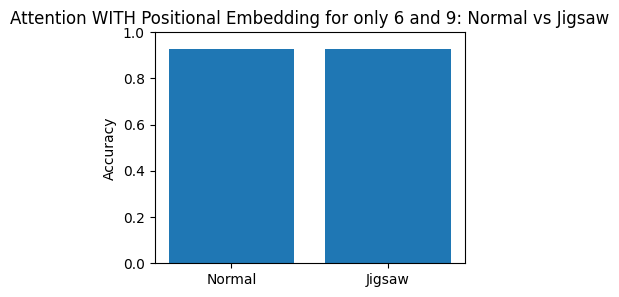


 Accuracy for Normal Image: 0.9263157894736842 
 Accuracy for Jigsaw Image: 0.9263157894736842


In [27]:
attn_69pos_normal = eval_attn_pos(attn_69pos, test_loader_69, jigsaw=False)
attn_69pos_jigsaw = eval_attn_pos(attn_69pos, test_loader_69, jigsaw=True)

plt.figure(figsize=(4,3))
plt.bar(["Normal", "Jigsaw"], [attn_69pos_normal, attn_69pos_jigsaw])
plt.ylabel("Accuracy")
plt.title("Attention WITH Positional Embedding for only 6 and 9: Normal vs Jigsaw")
plt.ylim(0,1)
plt.show()


print(f"\n Accuracy for Normal Image: {attn_69pos_normal} " f"\n Accuracy for Jigsaw Image: {attn_69pos_jigsaw}")

In [28]:
set_seed(31)

attn_pos = AttnWithPos().to(device)
attn_pos_opt = torch.optim.SGD(attn_pos.parameters(), lr=0.01)
steps_attn, losses_attn = train_attn_pos(attn_pos, attn_pos_opt, train_loader_0_9, epochs=10)

Epoch [1/10], Step [200/422], Loss: 2.2645
Epoch [1/10], Step [400/422], Loss: 2.0584
Epoch [2/10], Step [178/422], Loss: 1.7856
Epoch [2/10], Step [378/422], Loss: 1.5079
Epoch [3/10], Step [156/422], Loss: 1.4049
Epoch [3/10], Step [356/422], Loss: 1.3794
Epoch [4/10], Step [134/422], Loss: 1.2550
Epoch [4/10], Step [334/422], Loss: 1.2043
Epoch [5/10], Step [112/422], Loss: 1.1224
Epoch [5/10], Step [312/422], Loss: 1.0984
Epoch [6/10], Step [90/422], Loss: 1.1598
Epoch [6/10], Step [290/422], Loss: 1.0755
Epoch [7/10], Step [68/422], Loss: 0.9793
Epoch [7/10], Step [268/422], Loss: 1.0434
Epoch [8/10], Step [46/422], Loss: 0.8952
Epoch [8/10], Step [246/422], Loss: 1.1696
Epoch [9/10], Step [24/422], Loss: 1.0104
Epoch [9/10], Step [224/422], Loss: 0.8793
Epoch [10/10], Step [2/422], Loss: 0.8221
Epoch [10/10], Step [202/422], Loss: 0.9969
Epoch [10/10], Step [402/422], Loss: 0.7445


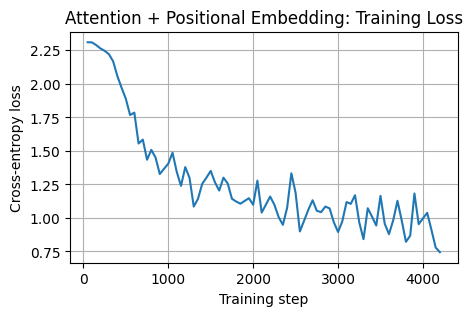

In [29]:
plt.figure(figsize=(5,3))
plt.plot(steps_attn, losses_attn)
plt.xlabel("Training step")
plt.ylabel("Cross-entropy loss")
plt.title("Attention + Positional Embedding: Training Loss")
plt.grid(True)
plt.show()

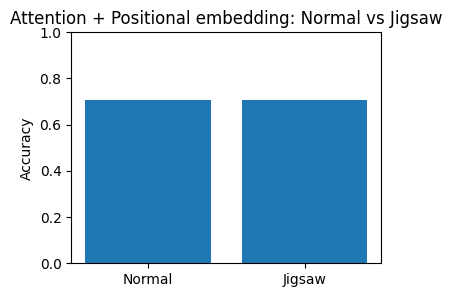


 Accuracy for Normal Image: 0.7089887640449438
 Accuracy for Jigsaw Image: 0.7089887640449438


In [30]:
attn_pos_normal = eval_attn_pos(attn_pos, test_loader_0_9, jigsaw=False)
attn_pos_jigsaw = eval_attn_pos(attn_pos, test_loader_0_9, jigsaw=True)

plt.figure(figsize=(4,3))
plt.bar(["Normal", "Jigsaw"], [attn_pos_normal, attn_pos_jigsaw])
plt.ylabel("Accuracy")
plt.title("Attention + Positional embedding: Normal vs Jigsaw")
plt.ylim(0,1)
plt.show()

print(f"\n Accuracy for Normal Image: {attn_pos_normal}" f"\n Accuracy for Jigsaw Image: {attn_pos_jigsaw}")

## Conclusion

### 1. The Role of Inductive Bias
*   **CNNs** rely heavily on **locality**. When we destroyed this structure (Jigsaw), the CNN's performance collapsed.
*   **Attention** is **permutation invariant**. The "No Position" model performed identically on Normal vs. Jigsaw images, confirming it treats images as a "bag of patches."

### 2. The Need for Positional embedding
Our experiments with the **6 vs. 9** subset revealed the critical limitation of the "bag of patches" approach.
*   Because 6 and 9 are geometrically rotations of each other, they share very similar patches.
*   The **No-Position** model failed to distinguish them, performing near chance level.
*   The **Positional embedding** model successfully learned the geometry, distinguishing 6 from 9 even when the image was scrambled.

### Final Answer
**Yes, positional embedding is necessary.** While patch content alone is sufficient for distinct classes (like 1 vs 8), **geometry is required** for structural disambiguation. Positional embeddings provide this missing signal, allowing attention models to understand "where" things are, not just "what" they are.

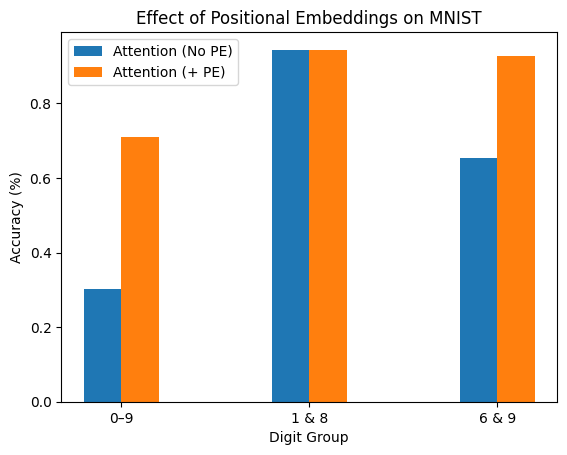

In [40]:
categories = ["0–9", "1 & 8", "6 & 9"]

att_without = [attn_nopos_normal, attn_18_normal, attn_69_normal]
att_with = [attn_pos_normal, attn_18pos_normal, attn_69pos_normal]

width = 0.2
x = [0, 1, 2]

plt.figure()

plt.bar([i-0.1 for i in x], att_without, width)
plt.bar([i+0.1 for i in x], att_with, width)

plt.xticks(x, categories)
plt.xlabel("Digit Group")
plt.ylabel("Accuracy (%)")
plt.title("Effect of Positional Embeddings on MNIST")

plt.legend(["Attention (No PE)", "Attention (+ PE)"])

plt.show()